In [11]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
import data_import_ephys as dimp
import scipy 
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from palettable import wesanderson as wes
import pingouin as pg      


In [12]:
def exp_mov_ave(data, tau = 8, initValue = 0.5, alpha = None):
    '''Exponential Moving average for 1d data.  The decay of the exponential can 
    either be specified with a time constant tau or a learning rate alpha.'''
    if not alpha: alpha = 1. - np.exp(-1./tau)
    mov_ave = np.zeros(np.size(data)+1)
    mov_ave[0] = initValue
    for i, x in enumerate(data):
        mov_ave[i+1] = (1.-alpha)*mov_ave[i] + alpha*x 
    return mov_ave[1:]


def task_ind(task, a_pokes, b_pokes): 
    """ Create Task IDs for that are consistent: in Task 1 A and B at left right extremes, in Task 2 B is one of the diagonal ones, 
    in Task 3  B is top or bottom """
    taskid = np.zeros(len(task));
    taskid[b_pokes == 10 - a_pokes] = 1     
    taskid[np.logical_or(np.logical_or(b_pokes == 2, b_pokes == 3), np.logical_or(b_pokes == 7, b_pokes == 8))] = 2  
    taskid[np.logical_or(b_pokes ==  1, b_pokes == 9)] = 3  
    
    return taskid

In [13]:
path = '/Users/veronikasamborska/Desktop/notebooks_paper/cells/data_recordings/'
def import_data(path):
    animals = ['m484', 'm479', 'm483', 'm478', 'm486', 'm480', 'm481'] 
    exp_record = []
    beh_path = path + 'behaviour/'
    for an in animals:
        path_animal = beh_path + an
        exp_record.append(dimp.Experiment(path_animal))
    return exp_record

experiment = import_data(path)



Loading new data files..
Importing data file: m484-2018-08-02-155106.txt
Importing data file: m484-2018-09-06-152427.txt
Importing data file: m484-2018-09-05-162702.txt
Importing data file: m484-2018-08-10-173911.txt
Importing data file: m484-2018-08-03-105809.txt
Importing data file: m484-2018-08-15-122753.txt
Importing data file: m484-2018-08-09-132608.txt
Importing data file: m484-2018-09-11-163452.txt
Importing data file: m484-2018-08-16-121147.txt
Importing data file: m484-2018-08-14-125426.txt
Importing data file: m484-2018-07-31-142630.txt
Importing data file: m484-2018-07-30-163447.txt
Importing data file: m484-2018-09-13-160920.txt
Importing data file: m484-2018-07-29-162954.txt
Importing data file: m484-2018-09-10-164953.txt
Importing data file: m484-2018-08-24-132334.txt
Importing data file: m484-2018-08-12-150904.txt
Importing data file: m484-2018-08-21-124141.txt
Importing data file: m484-2018-08-30-134542.txt
Importing data file: m484-2018-08-08-153806.txt
Importing data 

Importing data file: m480-2018-08-03-121147.txt
Importing data file: m480-2018-07-31-153557.txt
Importing data file: m480-2018-08-02-170827.txt
Importing data file: m480-2018-09-03-144707.txt
Importing data file: m480-2018-09-07-153149.txt
Importing data file: m480-2018-08-29-150714.txt
Importing data file: m480-2018-08-13-130356.txt
Importing data file: m480-2018-08-09-174252.txt
Importing data file: m480-2018-08-28-141717.txt
Importing data file: m480-2018-09-12-162114.txt
Importing data file: m480-2018-08-23-112420.txt
Importing data file: m480-2018-08-30-134542.txt
Importing data file: m480-2018-09-10-164953.txt
Importing data file: m480-2018-08-31-152055.txt
Importing data file: m480-2018-08-08-191004.txt
Importing data file: m480-2018-08-01-164435.txt
Importing data file: m480-2018-08-10-164351.txt
Loading new data files..
Importing data file: m481-2018-07-01-165322.txt
Importing data file: m481-2018-06-26-163533.txt
Importing data file: m481-2018-06-29-153244.txt
Importing data 

In [22]:
def trials_till_reversal_plot_recordings(experiment):
    all_subjects = []; tasks = 24; reversals = 4; n_subjects = len(experiment)
    for n_subj, subject_ID in enumerate(experiment):
        subject_sessions = subject_ID.get_sessions()
        all_sessions = [];
        for session in subject_sessions:         
            sessions_block = session.trial_data['block']
            prt = (session.trial_data['pre-reversal trials'] > 0).astype(int) # find trials where count till block reversal begins
            forced_trials = []; # delete forced trials
            events_forced = [event.name for event in session.events if event.name in ['init_trial','a_forced_state', 'b_forced_state']]
            for ev,event in enumerate(events_forced):
                if event == 'init_trial':
                    if ev < len(events_forced)-1:
                        if events_forced[ev+1] == 'a_forced_state' or events_forced[ev+1] == 'b_forced_state':
                            forced_trials.append(1)
                        else:
                            forced_trials.append(0)
            if len(forced_trials) > len(sessions_block):
                forced_trials = forced_trials[:len(sessions_block)] # sometimes session ends before the end of the trial
            forced_trials = np.asarray(forced_trials)
            forced_array = np.where(forced_trials == 1)[0]
            sessions_block = np.delete(sessions_block, forced_array)
            prt = np.delete(prt, forced_array)

            threshold_crossing_trials = np.where((prt[1:] - prt[:-1]) == 1)[0] #find trial indicies where animals crossed a threshold
            block_transitions = sessions_block[1:] - sessions_block[:-1] # find actual block transitions
            reversal_trials = np.where(block_transitions == 1)[0] # indicies of block transitions
           
            if len(threshold_crossing_trials) > 11: # only look at sessions for when 4 blocks in each task happened
                reversal_to_threshold = np.zeros((12)); reversal_number = 0
                reversal_to_threshold[:] = np.NaN
                for i, crossing_trial in enumerate(threshold_crossing_trials): 
                    if reversal_number <  12:
                        if i == 0: # first element in the threshold_crossing_trials_list 
                            reversal_to_threshold[reversal_number] = crossing_trial
                        else: # for other than the first thershold in the session calculate the number of trials since block change
                            reversal_to_threshold[reversal_number] = (crossing_trial-reversal_trials[i-1])
                      
                        reversal_number += 1  
                all_sessions.append([reversal_to_threshold[:4], reversal_to_threshold[4:8],\
                                        reversal_to_threshold[8:12]])

        all_sessions_sub = np.concatenate(all_sessions) 
        all_sessions_sub = all_sessions_sub[:tasks]
        all_subjects.append(all_sessions_sub)
   
    all_subjects = np.asarray(all_subjects)
    # organize data for ANOVAs
    rev = np.tile(np.arange(reversals),n_subjects*tasks); task_n = np.tile(np.repeat(np.arange(tasks),reversals),n_subjects); n_subj = np.repeat(np.arange(n_subjects),tasks*reversals)
    data = np.concatenate(all_subjects,0); data = np.concatenate(data,0)
    anova = {'Data':data,'Sub_id': n_subj,'cond1': task_n, 'cond2':rev}
    anova_pd = pd.DataFrame.from_dict(data = anova)
    aovrm = AnovaRM(anova_pd, depvar = 'Data',within=['cond1','cond2'], subject = 'Sub_id')
    res = aovrm.fit()
    posthoc = pg.pairwise_ttests(data = anova_pd, dv = 'Data',within = ['cond2'],subject = 'Sub_id',\
                             parametric = True, padjust = 'fdr_bh', effsize = 'hedges')
    print('Rev 1 vs 2:' + ' t = ' + str(np.round(posthoc['T'][0],3)) + ' dof: ' + str(posthoc['dof'][0]) + ' p = ' + str(np.round(posthoc['p-corr'][0],3)))
    print('Rev 1 vs 3:' + ' t = ' + str(np.round(posthoc['T'][1],3)) + ' dof: ' + str(posthoc['dof'][1]) + ' p = ' + str(np.round(posthoc['p-corr'][1],3)))
    print('Rev 1 vs 4:' + ' t = ' + str(np.round(posthoc['T'][2],3)) + ' dof: ' + str(posthoc['dof'][2]) + ' p = ' + str(np.round(posthoc['p-corr'][2],3)))

    print('Problem:' + ' '+ 'df'+ ' '+ str(res.anova_table['Num DF'][0]) + ' ' + str(res.anova_table['Den DF'][0]), 'F' + ' ' + str(np.round(res.anova_table['F Value'][0],3)),'p-val' + ' ' + str(np.round(res.anova_table['Pr > F'][0], 3)));
    print('Reversal:' + ' '+ 'df'+ ' '+ str(res.anova_table['Num DF'][1]) + ' ' + str(res.anova_table['Den DF'][1]), 'F' + ' ' + str(np.round(res.anova_table['F Value'][1],3)),'p-val' + ' ' + str(np.round(res.anova_table['Pr > F'][1], 3)));
   
 
    # Plot individual subjects
    mean_thre_subj = np.mean(all_subjects,axis = 2) 
    plt.figure(figsize=(7,7))      
    for i in mean_thre_subj:
        plt.scatter(np.arange(len(i)),i, color = 'grey')
        sns.despine()
        
    mean_threshold = np.mean(all_subjects,axis = 2) # mean across reversals
    mean_threshold_task = np.mean(mean_threshold, axis = 0) # mean across subjects
    std_threshold_per_task = np.std(mean_threshold, axis = 0) # std across subjects
    sample_size = np.sqrt(n_subjects)
    std_err = std_threshold_per_task/sample_size 
    
    # plot means and standard errors across tasks
    x_pos = np.arange(len(mean_threshold_task))
    plt.errorbar(x = x_pos, y = mean_threshold_task, yerr = std_err, alpha=0.8,  linestyle='None', marker='*', color = 'Black')    

    # plot trend line 
    z = np.polyfit(x_pos, mean_threshold_task,1) # linear fit
    p = np.poly1d(z)
    plt.plot(x_pos,p(x_pos),"--", color = 'grey', label = 'Trend Line')
    plt.xlabel("Problem Number")
    plt.ylabel("Number of Trials Till Threshold")
    plt.xticks(np.arange(len(x_pos)),np.arange(len(x_pos))+1)
    
    # plot all reversals across all tasks averaged aross subjects 
    x = np.arange(reversals)
    std_proportion = np.std(all_subjects, axis = 0)
    std_err = std_proportion/sample_size
    mean_thre_subj_all_tasks = np.mean(all_subjects,axis = 0) 
    
    
    plt.figure(figsize = (30,5))
    colors = wes.Moonrise5_6.mpl_colors+wes.Royal2_5.mpl_colors +wes.IsleOfDogs3_4.mpl_colors + wes.Margot1_5.mpl_colors + wes.Moonrise1_5.mpl_colors
    for i in range(tasks): 
        plt.plot(i * reversals + x, mean_thre_subj_all_tasks[i],  color = colors[i], label = 'Problem_'+str(i+1))
        plt.fill_between(i * reversals + x, mean_thre_subj_all_tasks[i] - std_err[i], mean_thre_subj_all_tasks[i]+std_err[i], alpha=0.2 ,color = colors[i])
    plt.xticks(np.arange(4*24),np.tile(np.arange(4)+1,24))
    #plt.legend()
    plt.ylabel('Number of Trials Till Threshold')
    plt.xlabel('Reversal Number')
    sns.despine()
    
    all_subj_mean_HP = np.mean(np.mean(all_subjects[:3],1),1)
    all_subj_mean_PFC = np.mean(np.mean(all_subjects[3:],1),1)
    stat = stats.ttest_ind(all_subj_mean_HP,all_subj_mean_PFC)
    print('CA1 vs PFC performance:' + 't = ' + str(np.round(stat.statistic,2)) + ' p-value = ' + str(np.round(stat.pvalue,2)));
    plt.figure(figsize = (5,6))
    plt.bar([0,1],[np.mean(all_subj_mean_HP),np.mean(all_subj_mean_PFC)], yerr = [np.std(all_subj_mean_HP)/np.sqrt(3),np.std(all_subj_mean_PFC)/np.sqrt(4)],\
            color = ['pink','purple'], zorder = 0)
    plt.scatter(np.zeros(len(all_subj_mean_HP)),all_subj_mean_HP, color = 'grey', zorder = 1)
    plt.scatter(np.ones(len(all_subj_mean_PFC)),all_subj_mean_PFC,  color = 'grey', zorder = 1)
    sns.despine()    
    plt.xticks([0,1],['CA1', 'PFC'])
    plt.ylabel('Number of Trials Till Threshold')


    
   
    
    
    

Rev 1 vs 2: t = -7.116 dof: 167.0 p = 0.0
Rev 1 vs 3: t = -8.21 dof: 167.0 p = 0.0
Rev 1 vs 4: t = -6.009 dof: 167.0 p = 0.0
Problem: df 23.0 138.0 F 1.471 p-val 0.09
Reversal: df 3.0 18.0 F 24.188 p-val 0.0
CA1 vs PFC performance:t = 0.42 p-value = 0.69


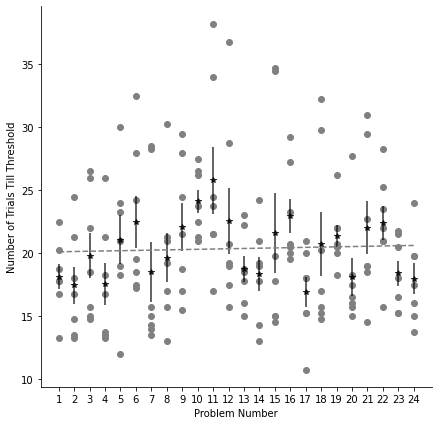

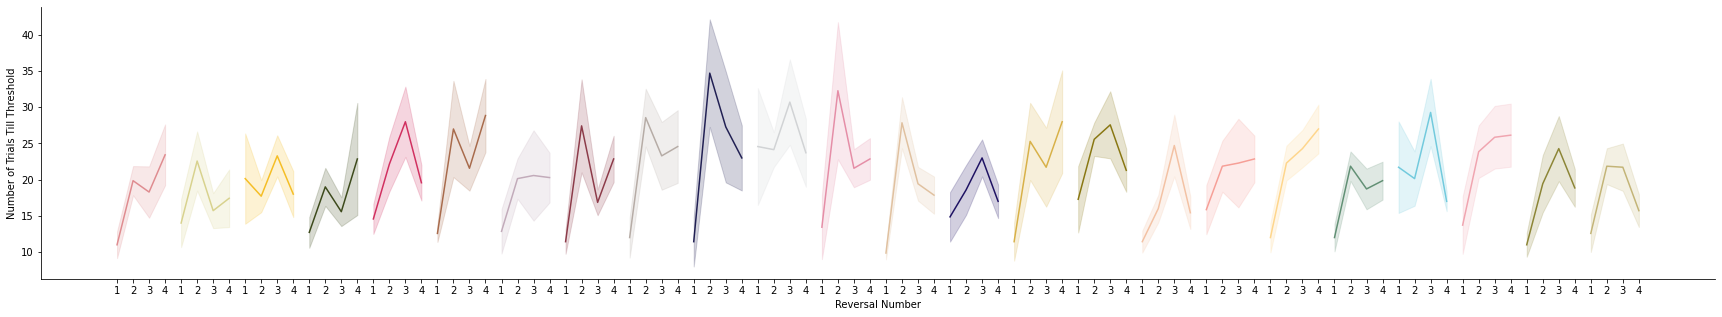

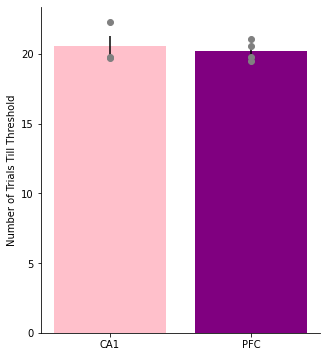

In [23]:
trials_till_reversal_plot_recordings(experiment)

In [20]:
def out_of_sequence_recordings(experiment, only_A_B = True):
    all_subjects = []; tasks = 24; reversals = 4; n_subjects = len(experiment)   

    for n_subj, subject_ID in enumerate(experiment):
        subject_sessions = subject_ID.get_sessions()
        
        all_sessions = []; 
        for sess,session in enumerate(subject_sessions): 
            sessions_block = session.trial_data['block']; task = session.trial_data['task']
            # delete forced trials
            events_forced = [event.name for event in session.events if event.name in ['init_trial','a_forced_state', 'b_forced_state']]
            forced_trials = []
            for ev,event in enumerate(events_forced):
                if event == 'init_trial':
                    if ev < len(events_forced)-1:
                        if events_forced[ev+1] == 'a_forced_state' or events_forced[ev+1] == 'b_forced_state':
                            forced_trials.append(1)
                        else:
                            forced_trials.append(0)
            if len(forced_trials) > len(sessions_block):
                forced_trials = forced_trials[:len(sessions_block)] # sometimes session ends before the end of the trial
            forced_trials = np.asarray(forced_trials)
            forced_array = np.where(forced_trials == 1)[0]
            sessions_block = np.delete(sessions_block, forced_array)
            task = np.delete(task, forced_array)
            poke_I = np.delete(session.trial_data['configuration_i'],forced_array) # find Initiation IDs
            poke_A = np.delete(session.trial_data['poke_A'], forced_array) # find As IDs
            poke_B = np.delete(session.trial_data['poke_B'], forced_array) # find Bs IDs
            task_1 = np.where(task == 1)[0]; task_2 = np.where(task == 2)[0]; task_3 = np.where(task == 3)[0]
            block_transitions = sessions_block[1:] - sessions_block[:-1] # find actual block transition
            reversal_trials = np.where(block_transitions == 1)[0]  
            if len(reversal_trials) > 11: # only look at sessions for when 4 blocks in each task happened
                poke_A_1 = 'poke_'+str(int(poke_A[task_1[0]])); poke_B_1 = 'poke_'+str(int(poke_B[task_1[0]]))
                poke_A_2 = 'poke_'+str(int(poke_A[task_2[0]])); poke_B_2 = 'poke_'+str(int(poke_B[task_2[0]]))
                poke_A_3 = 'poke_'+str(int(poke_A[task_3[0]])); poke_B_3 = 'poke_'+str(int(poke_B[task_3[0]]))
                poke_I_1 = 'poke_'+str(int(poke_I[task_1[0]])); poke_I_2 = 'poke_'+str(int(poke_I[task_2[0]]))
                poke_I_3 = 'poke_'+str(int(poke_I[task_3[0]]))
            

                # find events of interest
                events = [event.name for event in session.events if event.name in ['choice_state', 'init_trial','a_forced_state', 'b_forced_state',poke_A_1, poke_B_1,\
                                                                                   poke_A_2, poke_B_2,poke_A_3, poke_B_3,poke_I_1 ,\
                                                                                   poke_I_2,poke_I_3]]
    
                session_wrong_choice = []; # to append counts of wrong pokes
                choice_state_count = 0; choice_state = False
                wrong_count = 0
                for event in events:
                    if event == 'choice_state':
                        session_wrong_choice.append(wrong_count)
                        wrong_count = 0
                        choice_state = True
                        choice_state_count += 1
                    
                    elif event == 'a_forced_state' or event == 'b_forced_state':
                        prev_choice  = 'forced_state'
                        
                    # record task 1 out of sequence pokes           
                    if choice_state_count in task_1: # task 1 
                        if choice_state_count == task_1[0]: # first trial is always a forced 
                            prev_choice  = 'forced_state'
    
                        if event == poke_A_1: # 
                            if choice_state == True: 
                                prev_choice = 'Poke_A_1' # animal chose A during the choice phase
                                choice_state = False # indicate the animal made a choice 
                            elif choice_state == False and  prev_choice == 'Poke_B_1': # animal chose B previously
                                if event == poke_B_1:
                                    wrong_count += 1 # record if A poke was after an animal already chose B
                                        
                        elif event == poke_B_1 : 
                            if choice_state == True:
                                prev_choice = 'Poke_B_1' # animal chose B during the choice phase
                                choice_state = False # indicate the animal made a choice 
                            elif choice_state == False and prev_choice == 'Poke_A_1': # animal chose B previously
                                if event == poke_B_1:
                                    wrong_count += 1 # record if A poke was after an animal already chose B
                        
                        elif event == poke_I_2 or event == poke_I_3 or event == poke_A_2 or event == poke_A_3 or event == poke_B_2 or event == poke_B_3:
                            if event != poke_I_1 and only_A_B == False:
                                if choice_state == False and prev_choice == 'Poke_B_1' or prev_choice == 'Poke_A_1' :
                                    wrong_count += 1 
                      
                           
                    
                    # record task 2 out of sequence pokes  (same logic as above)                   
                    elif choice_state_count in task_2:
                        if choice_state_count == task_2[0]:
                            prev_choice  = 'forced_state'
    
                        if event == poke_A_2 : 
                            if choice_state == True:
                                prev_choice = 'Poke_A_2'
                                choice_state = False
                            elif choice_state == False and  prev_choice == 'Poke_B_2':
                                wrong_count += 1 
                            
                        elif event == poke_B_2: 
                            if choice_state == True:
                                prev_choice = 'Poke_B_2'
                                choice_state = False
                            elif choice_state == False and prev_choice == 'Poke_A_2':
                                wrong_count += 1 
                       
                        elif event == poke_I_1 or event == poke_I_3 or event == poke_A_1 or event == poke_A_3 or event == poke_B_1 or event == poke_B_3:
                            if event != poke_I_2 and only_A_B == False:
                                if choice_state == False and prev_choice == 'Poke_B_2' or prev_choice == 'Poke_A_2' :
                                    wrong_count += 1 
                      
                    # record task 3 out of sequence pokes  (same logic as above)                   
                    elif choice_state_count in task_3: 
                        if choice_state_count == task_3[0]:
                            prev_choice  = 'forced_state'
    
                        if event == poke_A_3 : 
                            if choice_state == True:
                                prev_choice = 'Poke_A_3'
                                choice_state = False
                                
                            elif choice_state == False and  prev_choice == 'Poke_B_3':
                                wrong_count += 1 
                            
                        elif event == poke_B_3: 
                            if choice_state == True:
                                prev_choice = 'Poke_B_3'
                                choice_state = False
                            elif choice_state == False and prev_choice == 'Poke_A_3':
                                wrong_count += 1 
                        
                        elif event == poke_I_1 or event == poke_I_2 or event == poke_A_2 or event == poke_A_1 or event == poke_B_2 or event == poke_B_1:
                            if event != poke_I_3 and only_A_B == False:
                                if choice_state == False and prev_choice == 'Poke_B_3' or prev_choice == 'Poke_A_3' :
                                    wrong_count += 1 
                      
                session_wrong_choice = session_wrong_choice[:len(task)] 
                reversal_trials = np.insert(reversal_trials,0,0)
                reversal_trials = np.append(reversal_trials,len(task)); reversal_mean = []
                for i,revs in enumerate(reversal_trials):
                     if i > 0 and i < len(reversal_trials)-1:
                        reversal_mean.append(np.mean(session_wrong_choice[reversal_trials[i-1]:revs]))
                         
                
                   
                all_sessions.append([reversal_mean[:4], reversal_mean[4:8],\
                                        reversal_mean[8:12]])
        all_sessions_sub = np.concatenate(all_sessions) 
        all_sessions_sub = all_sessions_sub[:tasks]
        all_subjects.append(all_sessions_sub)
    all_subjects = np.asarray(all_subjects)
    # organize data for ANOVAs
    rev = np.tile(np.arange(reversals),n_subjects*tasks); task_n = np.tile(np.repeat(np.arange(tasks),reversals),n_subjects); n_subj = np.repeat(np.arange(n_subjects),tasks*reversals)
    data = np.concatenate(all_subjects,0); data = np.concatenate(data,0)
     
    anova = {'Data':data,'Sub_id': n_subj,'cond1': task_n, 'cond2':rev}
    anova_pd = pd.DataFrame.from_dict(data = anova)
    aovrm = AnovaRM(anova_pd, depvar = 'Data',within=['cond1','cond2'], subject = 'Sub_id')
    res = aovrm.fit()
    posthoc = pg.pairwise_ttests(data = anova_pd, dv = 'Data',within = ['cond2'],subject = 'Sub_id',\
                             parametric = True, padjust = 'fdr_bh', effsize = 'hedges')
    print('Rev 1 vs 2:' + ' t = ' + str(np.round(posthoc['T'][0],3)) + ' dof: ' + str(posthoc['dof'][0]) + ' p = ' + str(np.round(posthoc['p-corr'][0],3)))
    print('Rev 1 vs 3:' + ' t = ' + str(np.round(posthoc['T'][1],3)) + ' dof: ' + str(posthoc['dof'][1]) + ' p = ' + str(np.round(posthoc['p-corr'][1],3)))
    print('Rev 1 vs 4:' + ' t = ' + str(np.round(posthoc['T'][2],3)) + ' dof: ' + str(posthoc['dof'][2]) + ' p = ' + str(np.round(posthoc['p-corr'][2],3)))

    # print stats
    print('Problem:' + ' '+ 'df'+ ' '+ str(res.anova_table['Num DF'][0]) + ' ' + str(res.anova_table['Den DF'][0]), 'F' + ' ' + str(np.round(res.anova_table['F Value'][0],3)),'p-val' + ' ' + str(np.round(res.anova_table['Pr > F'][0], 3)));
    print('Reversal:' + ' '+ 'df'+ ' '+ str(res.anova_table['Num DF'][1]) + ' ' + str(res.anova_table['Den DF'][1]), 'F' + ' ' + str(np.round(res.anova_table['F Value'][1],3)),'p-val' + ' ' + str(np.round(res.anova_table['Pr > F'][1], 3)));
   
    # Plot individual subjects
    mean_thre_subj = np.mean(all_subjects,axis = 2) 
    plt.figure(figsize=(7,7))      
    for i in mean_thre_subj:
        plt.scatter(np.arange(len(i)),i, color = 'grey')
        sns.despine()
        
    mean_threshold = np.mean(all_subjects,axis = 2) # mean across reversals
    mean_threshold_task = np.mean(mean_threshold, axis = 0) # mean across subjects
    std_threshold_per_task = np.std(mean_threshold, axis = 0) # std across subjects
    sample_size = np.sqrt(n_subjects)
    std_err = std_threshold_per_task/sample_size 
    
    # plot means and standard errors across tasks
    x_pos = np.arange(len(mean_threshold_task))
    plt.errorbar(x = x_pos, y = mean_threshold_task, yerr = std_err, alpha = 0.8,  linestyle='None', marker='*', color = 'Black')    

    # plot trend line 
    z = np.polyfit(x_pos, mean_threshold_task,1) # linear fit
    p = np.poly1d(z)
    plt.plot(x_pos,p(x_pos),"--", color = 'grey', label = 'Trend Line')
    plt.xlabel("Problem Number")
    plt.ylabel('Out of Sequence Pokes')
    plt.xticks(np.arange(len(x_pos)),np.arange(len(x_pos))+1)
    
    # plot all reversals across all tasks averaged aross subjects 
    x = np.arange(reversals)
    std_proportion = np.std(all_subjects, axis = 0)
    std_err = std_proportion/sample_size
    mean_thre_subj_all_tasks = np.mean(all_subjects,axis = 0) 
    
    
    plt.figure(figsize = (30,5))
    colors = wes.Moonrise5_6.mpl_colors+wes.Royal2_5.mpl_colors +wes.IsleOfDogs3_4.mpl_colors + wes.Margot1_5.mpl_colors + wes.Moonrise1_5.mpl_colors
    for i in range(tasks): 
        plt.plot(i * reversals + x, mean_thre_subj_all_tasks[i],  color = colors[i], label = 'Problem_'+str(i+1))
        plt.fill_between(i * reversals + x, mean_thre_subj_all_tasks[i] - std_err[i], mean_thre_subj_all_tasks[i]+std_err[i], alpha=0.2 ,color = colors[i])
    plt.xticks(np.arange(4*24),np.tile(np.arange(4)+1,24))
    #plt.legend()
    plt.ylabel('Out of Sequence Pokes')
    plt.xlabel('Reversal Number')
    sns.despine()
    
    xs = [1,2,3,4]
    rev  = []; st = []
    for i in xs:
        rev.append(np.mean(np.mean(all_subjects,1),0)[i-1])
        st.append(np.std(np.mean(all_subjects,1),0)[i-1]/np.sqrt(n_subjects))
    subj_pokes_rev = np.mean(all_subjects,1)

    z = np.polyfit(xs, rev,1)
    p = np.poly1d(z)
    plt.figure()
    plt.plot(xs,p(xs),"--", color = 'grey', label = 'Trend Line')
    k = 0
    for i in subj_pokes_rev:
        plt.scatter(np.arange(len(i))+1,i,  color = 'Black')
        sns.despine()
 
    plt.errorbar(x = xs, y = rev, yerr = st, alpha=0.8,  linestyle='None', marker='*', color = 'Black')    
    plt.ylabel('Mean Number of Out of Sequence Pokes')
    plt.xlabel('Reversal Number')
    plt.xticks(xs, xs)
    
    all_subj_mean_HP = np.mean(np.mean(all_subjects[:3],1),1)
    all_subj_mean_PFC = np.mean(np.mean(all_subjects[3:],1),1)
    stat = stats.ttest_ind(all_subj_mean_HP,all_subj_mean_PFC)
    print('CA1 vs PFC performance:' + 't = ' + str(np.round(stat.statistic,2)) + ' p-value = ' + str(np.round(stat.pvalue,2)));

    plt.figure(figsize = (5,6))
    plt.bar([0,1],[np.mean(all_subj_mean_HP),np.mean(all_subj_mean_PFC)], yerr = [np.std(all_subj_mean_HP)/np.sqrt(3),np.std(all_subj_mean_PFC)/np.sqrt(4)],\
            color = ['pink','purple'],zorder = 0)
    plt.scatter(np.zeros(len(all_subj_mean_HP)),all_subj_mean_HP, color = 'grey', zorder = 1)
    plt.scatter(np.ones(len(all_subj_mean_PFC)),all_subj_mean_PFC,  color = 'grey', zorder = 1)
    sns.despine()  
    plt.xticks([0,1],['CA1', 'PFC'])
    plt.ylabel('Mean Number of Out of Sequence Pokes')


    
   
    
    
      

Rev 1 vs 2: t = 2.614 dof: 167.0 p = 0.015
Rev 1 vs 3: t = 3.844 dof: 167.0 p = 0.001
Rev 1 vs 4: t = 4.154 dof: 167.0 p = 0.0
Problem: df 23.0 138.0 F 0.997 p-val 0.474
Reversal: df 3.0 18.0 F 11.123 p-val 0.0
CA1 vs PFC performance:t = -1.39 p-value = 0.22


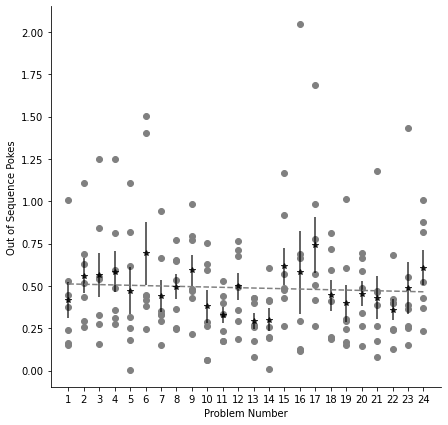

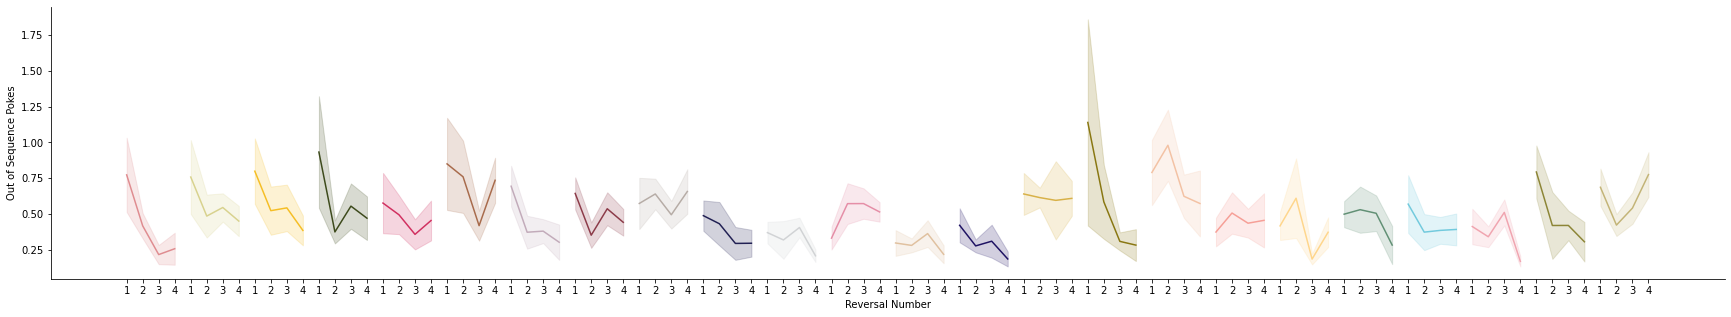

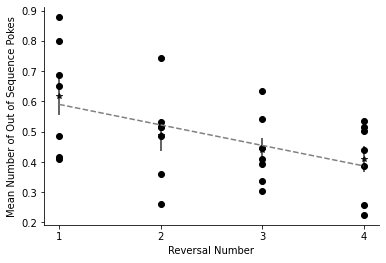

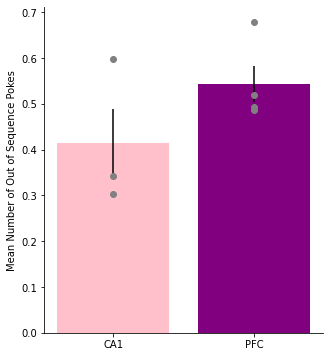

In [21]:
out_of_sequence_recordings(experiment, only_A_B = False)

In [9]:
def forced_trials_(experiment):
    As_state_a_b_s = []; Bs_state_a_b_s = []    
    As_state_b_a_s = []; Bs_state_b_a_s = []

    other_state_b_subj = []; other_state_a_subj = []
    
    for n_subj, subject_ID in enumerate(experiment):
        subject_sessions = subject_ID.get_sessions()
        
        As_state_a_b = [];  Bs_state_a_b = []; 
        As_state_b_a = []; Bs_state_b_a =[];

        other_state_b = []; other_state_a = []
        for sess,session in enumerate(subject_sessions): 
            choices = session.trial_data['choices']; sessions_block = session.trial_data['block']
            state = session.trial_data['state']; task = session.trial_data['task']
            task_1 = np.where(task  == 1)[0];  task_2 = np.where(task  == 2)[0]; task_3 = np.where(task  == 3)[0]
            events_forced = [event.name for event in session.events if event.name in ['init_trial','a_forced_state', 'b_forced_state']]
            forced_trials = []
            
            c_1 = np.where(state[task_1] == choices[task_1])[0]
            correct_1  = np.zeros(len(choices[task_1]))
            correct_1[c_1] = 1
            exp_average_1 = exp_mov_ave(correct_1,initValue = 0.5,tau = 8)

            c_2 = np.where(state[task_2] == choices[task_2])[0]
            correct_2  = np.zeros(len(choices[task_2]))
            correct_2[c_2] = 1
            exp_average_2 = exp_mov_ave(correct_2,initValue = 0.5,tau = 8)

            c_3 = np.where(state[task_3] == choices[task_3])[0]
            correct_3  = np.zeros(len(choices[task_3]))
            correct_3[c_3] = 1
            exp_average_3 = exp_mov_ave(correct_3,initValue = 0.5,tau = 8)
            exp_av = np.hstack([exp_average_1,exp_average_2,exp_average_3])

            correct = np.hstack([correct_1,correct_2,correct_3])
            reward = session.trial_data['outcomes']; corr_rew = correct*reward
            corr_rew = np.insert(corr_rew,0,0); 
            cum = [0]; cum_ = 0
            for crr,cor in enumerate(corr_rew):
                cum_ = cum_+ corr_rew[crr]
                cum.append(cum_)
                if corr_rew[crr] == 0:
                    cum_ = 0 
            cum  = np.asarray(cum[:len(reward)])
            for ev,event in enumerate(events_forced):
                if event == 'init_trial':
                    if ev < len(events_forced)-1:
                        if events_forced[ev+1] == 'a_forced_state' or events_forced[ev+1] == 'b_forced_state':
                            forced_trials.append(1)
                        else:
                            forced_trials.append(0)
                          
            if len(forced_trials) > len(choices):
                forced_trials = forced_trials[:len(choices)] # sometimes session ends before the end of the trial 
            
            forced_trials = np.asarray(forced_trials);  forced_array = np.where(forced_trials == 1)[0] # delete non-forced trials 
            state = state[forced_array]; task = task[forced_array]
            poke_I = session.trial_data['configuration_i'][forced_array] # find Initiation IDs
            poke_A = session.trial_data['poke_A'][forced_array] # find As IDs
            poke_B = session.trial_data['poke_B'][forced_array] # find Bs IDs
            block_transitions = sessions_block[1:] - sessions_block[:-1] # find actual block transition
            reversal_trials = np.where(block_transitions == 1)[0]  
            task_1 = np.where(task  == 1)[0];  task_2 = np.where(task  == 2)[0]; task_3 = np.where(task  == 3)[0]
            corr_rew = cum[forced_array]; exp_av = exp_av[forced_array]
            
            if len(reversal_trials) > 11: # only look at sessions for when 4 blocks in each task happened
                choice_pokes_1 = [poke_A[task_1[0]], poke_B[task_1[0]]]; choice_pokes_2 = poke_A[task_2[0]], poke_B[task_2[0]]; choice_pokes_3 = poke_A[task_3[0]], poke_B[task_3[0]]
                find_A_idenity = np.unique([poke_A[task_1[0]], poke_B[task_1[0]], poke_A[task_2[0]], poke_B[task_2[0]], poke_A[task_3[0]], poke_B[task_3[0]]], return_counts = True)
                As = find_A_idenity[0][np.where(find_A_idenity[1] == 3)[0]]
                poke_A_1 = 'poke_'+ str(As[0]); poke_A_2 = 'poke_'+ str(As[0]); poke_A_3 = 'poke_'+ str(As[0])
                for ch in choice_pokes_1:
                    if ch != As[0]:
                        poke_B_1 = 'poke_'+ str(ch)
                for ch in choice_pokes_2:
                    if ch != As[0]:
                        poke_B_2 = 'poke_'+ str(ch)
                for ch in choice_pokes_3:
                    if ch != As[0]:
                        poke_B_3 = 'poke_'+ str(ch)
                        
                poke_I_1 = 'poke_'+str(int(poke_I[task_1[0]])); poke_I_2 = 'poke_'+str(int(poke_I[task_2[0]]))
                poke_I_3 = 'poke_'+str(int(poke_I[task_3[0]]))
                poke_A_1_rec_script = 'poke_'+str(int(poke_A[task_1[0]])); 
                poke_A_2_rec_script = 'poke_'+str(int(poke_A[task_2[0]]));
                poke_A_3_rec_script = 'poke_'+str(int(poke_A[task_3[0]])); 
                
                state_1 = state[task_1]; state_2 = state[task_2]; state_3 = state[task_3]; 
                if poke_A_1_rec_script != poke_A_1:
                    state_1 = (-1 + state_1)*(-1)
                if poke_A_2_rec_script != poke_A_2:
                    state_2 = (-1 + state_2)*(-1)
                elif poke_A_3_rec_script != poke_A_3:
                    state_3 = (-1 + state_3)*(-1)
                state = np.hstack([state_1, state_2, state_3])   
                events = [event for event in session.events if event.name in ['choice_state', 'init_trial','a_forced_state', 'b_forced_state',poke_A_1, poke_B_1,\
                                                                                       poke_A_2, poke_B_2,poke_A_3, poke_B_3,poke_I_1 ,\
                                                                                       poke_I_2,poke_I_3]]
                forced_a_b = []; forced = []; forced_count = 0
                for e,event in enumerate(events):
                    if event.name == 'a_forced_state' or event.name == 'b_forced_state':    
                            forced_count += 1
                            trial = []
                            if (e+1) < len(events):
                                while events[e+1].name != 'init_trial':
                                    trial.append(events[e+1])
                                    if (e+2) < len(events):
                                        e+=1
                                    else:
                                        break     
                            forced.append(trial)
                            if event.name == 'a_forced_state':
                                forced_a_b.append(1)
                            elif event.name == 'b_forced_state':
                                forced_a_b.append(0)
                pokes = []
                if len(forced_a_b)> len(task):
                    forced_a_b = forced_a_b[:len(task)]
                forced_1 = np.asarray(forced_a_b)[task_1]; forced_2 = np.asarray(forced_a_b)[task_2]; forced_3 = np.asarray(forced_a_b)[task_3]; 
                if poke_A_1_rec_script != poke_A_1:
                    forced_1 = (-1 + forced_1)*(-1)
                if poke_A_2_rec_script != poke_A_2:
                    forced_2 = (-1 + forced_2)*(-1)
                elif poke_A_3_rec_script != poke_A_3:
                    forced_3 = (-1 + forced_3)*(-1)
                forced_a_b = np.hstack([forced_1, forced_2, forced_3])
                
                for f,ff in enumerate(forced):
                    if f in task_1: 
                        choice_state = False
                        for i in forced[f]:
                            if choice_state == False:
                                if i.name == poke_B_1 or i.name == poke_A_1:
                                    choice_state = True
                                    if i.name == poke_B_1:
                                        pokes.append(0)

                                    elif i.name == poke_A_1:
                                        pokes.append(1)

                                elif i.name == poke_B_2 or i.name == poke_A_2 or i.name == poke_B_3 or i.name == poke_A_3\
                                    or i.name == poke_I_2 or i.name == poke_I_3:
                                    if i.name != poke_I_1:
                                        pokes.append(2) # other choices
                                        choice_state = True         

                    elif f in task_2:
                        choice_state = False
                        for i in forced[f]:
                            if choice_state == False:
                                if i.name == poke_B_2 or i.name == poke_A_2:
                                    choice_state = True
                                    if i.name == poke_B_2:
                                        pokes.append(0)
                                    elif i.name == poke_A_2:
                                        pokes.append(1)

                                elif i.name == poke_B_1 or i.name == poke_A_1 or i.name == poke_B_3 or i.name == poke_A_3\
                                    or i.name == poke_I_3 or i.name == poke_I_1:
                                    if i.name != poke_I_2:
                                        pokes.append(2) # other choices
                                        choice_state = True
          
                    elif f in task_3:
                        choice_state = False
                        for i in forced[f]:
                            if choice_state == False:
                                if i.name == poke_B_3 or i.name == poke_A_3:
                                    choice_state = True
                                    if i.name == poke_B_3:
                                        pokes.append(0)
                                    elif i.name == poke_A_3:
                                        pokes.append(1)

                                elif i.name == poke_B_1 or i.name == poke_A_1 or i.name == poke_B_2 or i.name == poke_A_2\
                                    or i.name == poke_I_2 or i.name == poke_I_1:
                                    if i.name != poke_I_3:
                                        pokes.append(2) # other choices
                                        choice_state = True
                                

                # forced B trials in A good
                exp_threshold = np.where(exp_av > 0.7)[0]
                forced_b_state_a = np.intersect1d(np.where(np.asarray(forced_a_b) == 0)[0], np.where(state == 1)[0])
                forced_b_state_a = np.intersect1d(forced_b_state_a, exp_threshold) 
                forced_b_state_a = np.intersect1d(forced_b_state_a, np.where(corr_rew > 1)[0])
                count_b_f = np.asarray(pokes)[forced_b_state_a]  # pokes on forced B trials in A good
                forced_bs, counts_fb = np.unique(count_b_f, return_counts = True)  # pokes on forced B trials in A good

                other_in_bs = counts_fb[np.where(forced_bs == 2)[0]]/len(forced_b_state_a) # other Ch on B forced when A good
                as_in_bs = counts_fb[np.where(forced_bs == 1)[0]]/len(forced_b_state_a) # A Ch on B forced when A good
                bs_in_bs = counts_fb[np.where(forced_bs == 0)[0]]/len(forced_b_state_a) # A Ch on B forced when A good
                
                # forced A trials in B good
                forced_a_state_b = np.intersect1d(np.where(np.asarray(forced_a_b) == 1)[0], np.where(state == 0)[0])
                forced_a_state_b = np.intersect1d(forced_a_state_b, exp_threshold)
                forced_a_state_b = np.intersect1d(forced_a_state_b, np.where(corr_rew > 1)[0])

                count_a_f = np.asarray(pokes)[forced_a_state_b] # pokes on forced A trials in B good
                forced_as, counts_fa = np.unique(count_a_f, return_counts = True) # pokes on forced A trials in B good
                other_in_as = counts_fa[np.where(forced_as == 2)[0]]/len(forced_a_state_b) # other Ch on A forced when B good
                as_in_as = counts_fa[np.where(forced_as == 1)[0]]/len(forced_a_state_b) # A Ch on A forced when B good
                bs_in_as = counts_fa[np.where(forced_as == 0)[0]]/len(forced_a_state_b) # B Ch on A forced when B good
                
                if len(as_in_bs) > 0:
                    As_state_a_b.append(as_in_bs) 
                else:
                    As_state_a_b.append(np.asarray([0]))

                if len(other_in_bs) > 0:
                    other_state_b.append(other_in_bs)
                else:
                    other_state_b.append(np.asarray([0]))

                if len(bs_in_bs) > 0:
                    Bs_state_a_b.append(bs_in_bs) 
                else:
                    Bs_state_a_b.append(np.asarray([0]))

                if len(as_in_as) > 0:
                    As_state_b_a.append(as_in_as) 
                else:
                    As_state_b_a.append(np.asarray([0]))

                if len(other_in_as) > 0:
                    other_state_a.append(other_in_as)
                else:
                    other_state_a.append(np.asarray([0]))

                if len(bs_in_as) > 0:
                    Bs_state_b_a.append(bs_in_as) 
                else:
                    Bs_state_b_a.append(np.asarray([0]))

        other_state_b_subj.append(np.mean(other_state_b))
        other_state_a_subj.append(np.mean(other_state_a))

        As_state_a_b_s.append(np.mean(As_state_a_b)) # A choices in B forced  when A is good
        Bs_state_a_b_s.append(np.mean(Bs_state_a_b)) # B choices in B forced when A is good
        
        As_state_b_a_s.append(np.mean(As_state_b_a)) # A choices in forced A when B is good
        Bs_state_b_a_s.append(np.mean(Bs_state_b_a)) # B choices in forced A when B is good
       
    return As_state_a_b_s, Bs_state_a_b_s, As_state_b_a_s, Bs_state_b_a_s, other_state_b_subj, other_state_a_subj
        
            

In [10]:
def plot_forced(experiment):   
    As_state_a_b_s, Bs_state_a_b_s, As_state_b_a_s, Bs_state_b_a_s,\
    other_state_b_subj, other_state_a_subj = forced_trials_(experiment)

    d_a = np.hstack([As_state_b_a_s,Bs_state_b_a_s,other_state_a_subj]) # A forced B good 
    d_b = np.hstack([As_state_a_b_s,Bs_state_a_b_s,other_state_b_subj]) # B forced A good

    a_b = scipy.stats.ttest_rel(As_state_b_a_s,Bs_state_b_a_s)
    b_a = scipy.stats.ttest_rel(Bs_state_a_b_s,As_state_a_b_s)

    a_oth = scipy.stats.ttest_rel(Bs_state_b_a_s,other_state_a_subj)
    b_oth = scipy.stats.ttest_rel(As_state_a_b_s,other_state_b_subj)
    
    print('A vs B in A forced B good:' + ' t = ' + str(np.round(a_b.statistic,2)) + ' p-value = ' + str(np.round(a_b.pvalue,2)));
    print('B vs other in A forced B good:' + ' t = ' + str(np.round(a_oth.statistic,2)) + ' p-value = ' + str(np.round(a_oth.pvalue,2)));
    print('A vs B in B forced A good:' +  ' t = ' + str(np.round(b_a.statistic,2)) + ' p-value = ' + str(np.round(b_a.pvalue,2)));
    print('A vs other in B forced A good:'+ ' t = ' + str(np.round(b_oth.statistic,2)) + ' p-value = ' + str(np.round(b_oth.pvalue,2)));

    d_str = np.hstack([np.tile('As',7),np.tile('Bs',7), np.tile('Other',7)])
    data = {'Choice Probability': d_a, 'Poke Identity': d_str}
    df_a = pd.DataFrame(data=data)

    d_str = np.hstack([np.tile('As',7),np.tile('Bs',7), np.tile('Other',7)])
    data_b = {'Choice Probability': d_b, 'Poke Identity': d_str}
    df_b = pd.DataFrame(data=data_b)

    g = sns.catplot(x="Poke Identity", y="Choice Probability",kind="box", data=df_a, palette="ch:.25")
    sns.swarmplot(x="Poke Identity", y="Choice Probability", color="k", size=3, data=df_a, ax=g.ax)
    plt.title('B good, A forced')
    plt.tight_layout()


    g_1 = sns.catplot(x="Poke Identity", y="Choice Probability",
            kind="box", data=df_b,  palette="ch:.25")
    sns.swarmplot(x="Poke Identity", y="Choice Probability", color="k", size=3, data=df_b, ax=g_1.ax)
    plt.title('A good, B forced')
    plt.tight_layout()



A vs B in A forced B good: t = 0.76 p-value = 0.47
B vs other in A forced B good: t = 6.25 p-value = 0.0
A vs B in B forced A good: t = 1.45 p-value = 0.2
A vs other in B forced A good: t = 2.94 p-value = 0.03


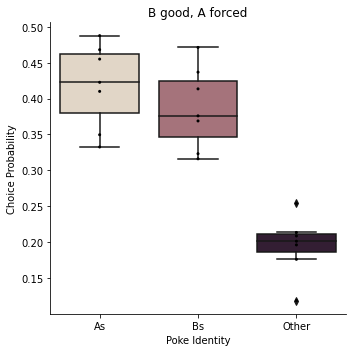

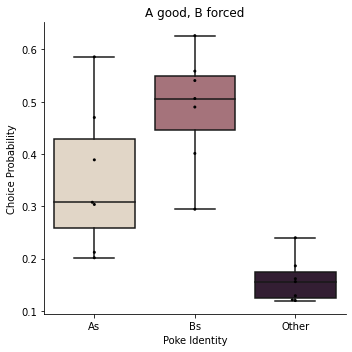

In [12]:
plot_forced(experiment)